In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from scipy.signal import convolve
from tqdm import tqdm
import os
import pandas as pd


import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
import time
start_time = time.time()

In [3]:
# detection parameters
Npix_min = 45*45 #20*6*5
Npix_max = 500*6*5
OW_thr_factor =-0.2

sigma = 9 # smoothing parameter
wx = int(100*15) # rolling window size in x-direction
wy = int(100*15) # rolling window size in y-direction

In [4]:
datestart, dateend = "2012-04-10", "2012-05-04"
#periods = [
#    ("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"),
#    ("2012-03-16", "2012-04-09"), ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [5]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset('/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/suppl/2_INALT60.L120-KRS0020_mesh_mask.nc') 
indices = np.concatenate((range(0, 11, 10),range(18, 25, 6),range(29, 34, 4),range(36, 40, 3),range(41, 120, 2)))
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in indices]
print(len(depth_information),depth_information)

48 [(0, 0), (21, 10), (54, 18), (91, 24), (132, 29), (173, 33), (210, 36), (253, 39), (286, 41), (323, 43), (365, 45), (412, 47), (465, 49), (525, 51), (592, 53), (668, 55), (753, 57), (848, 59), (952, 61), (1066, 63), (1189, 65), (1321, 67), (1461, 69), (1608, 71), (1762, 73), (1922, 75), (2086, 77), (2255, 79), (2428, 81), (2603, 83), (2782, 85), (2963, 87), (3146, 89), (3331, 91), (3518, 93), (3706, 95), (3896, 97), (4086, 99), (4279, 101), (4472, 103), (4666, 105), (4861, 107), (5057, 109), (5254, 111), (5452, 113), (5651, 115), (5850, 117), (6050, 119)]


In [6]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

### Detection

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [7]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': datestart, # time range start
                        'end_time': dateend, # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 0, # minimum longitude of detection region
                        'lon2': 40, # maximum longitude
                        'lat1': -45, # minimum latitude
                        'lat2': -25, # maximum latitude
                        'min_dep': 100, # minimum ocean depth where to look for eddies in m, masking out areas shallower than value
                        'res': 1./60., # resolution of the fields in degree
                        #'OW_thr': data_int,#['OW_std'].values, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': OW_thr_factor, # Okubo-Weiss parameter threshold
                        'Npix_min': Npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': Npix_max, # maximum number of pixels (grid cells)
                        'no_long': False, # If True, elongated shapes will not be considered
                        'no_two': False # If True, eddies with two minima in the OW
                                        # parameter and a OW > OW_thr in between  will not
                                        # be considered
                       }

In [8]:
def plot_eddies(data_int, eddies, detection_parameters, datestart, depth):
    """Plot a single time step to see what the detection method detected"""
    t = 0 
    d_p = detection_parameters
    plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.OW.isel(time=t).values,
                   vmin=-1e-9, vmax=1e-9, cmap=cm.balance, shading='auto')
    for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
        plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
                 [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
                 color=c, linestyle=l)
    
    for i in np.arange(0, len(eddies[t])):
        if eddies[t][i]['lon'] < 0:
            eddy_lon = eddies[t][i]['lon'] + 360
        else:
            eddy_lon = eddies[t][i]['lon']
        if eddies[t][i]['type'] == 'cyclonic':
            for s, c in zip([7, 6], ['k', 'gold']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
        elif eddies[t][i]['type'] == 'anticyclonic':
            for s, c in zip([7, 6], ['k', 'silver']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

    plt.title(datestart + ' - ' + str(depth) + 'm')
    plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

> Starting: 20120410, 0m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


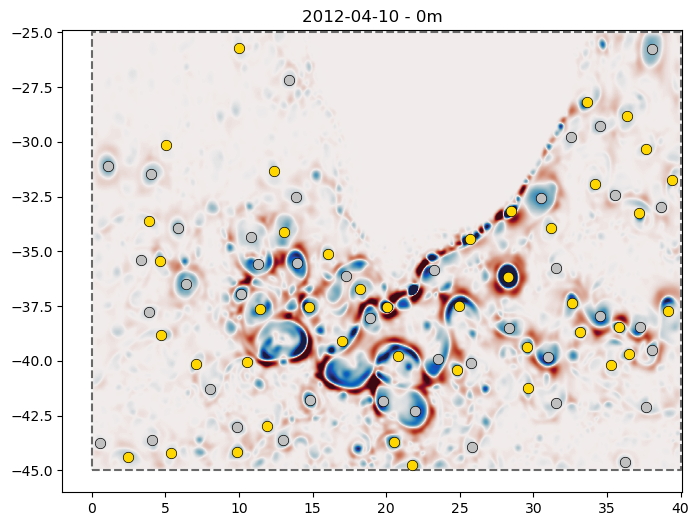

  2%|▏         | 1/48 [01:18<1:01:47, 78.88s/it]

> Starting: 20120410, 21m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


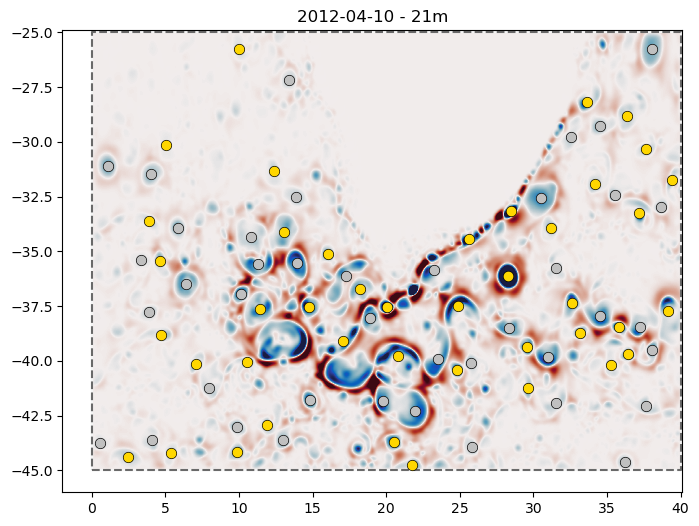

  4%|▍         | 2/48 [02:35<59:14, 77.27s/it]  

> Starting: 20120410, 54m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


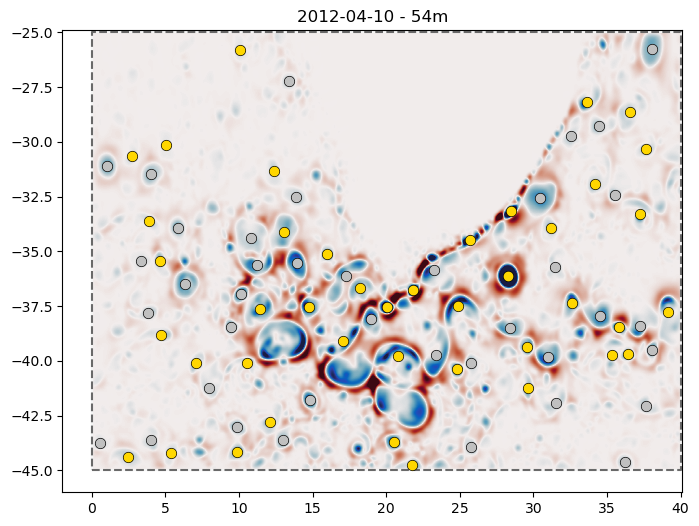

  6%|▋         | 3/48 [03:50<57:14, 76.31s/it]

> Starting: 20120410, 91m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


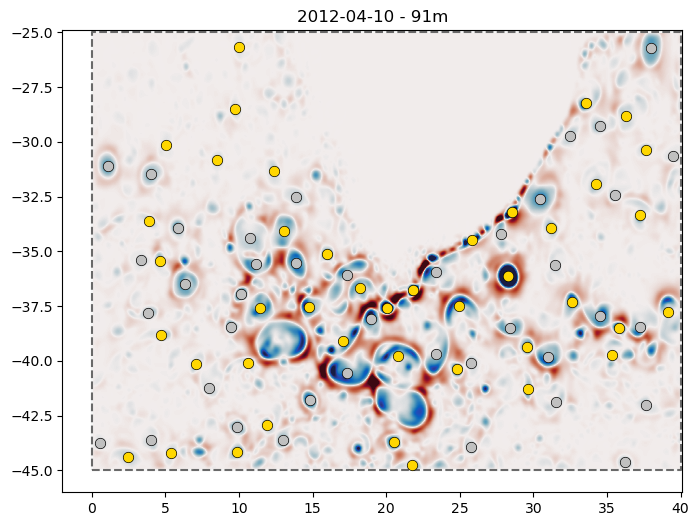

  8%|▊         | 4/48 [05:05<55:43, 75.98s/it]

> Starting: 20120410, 132m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


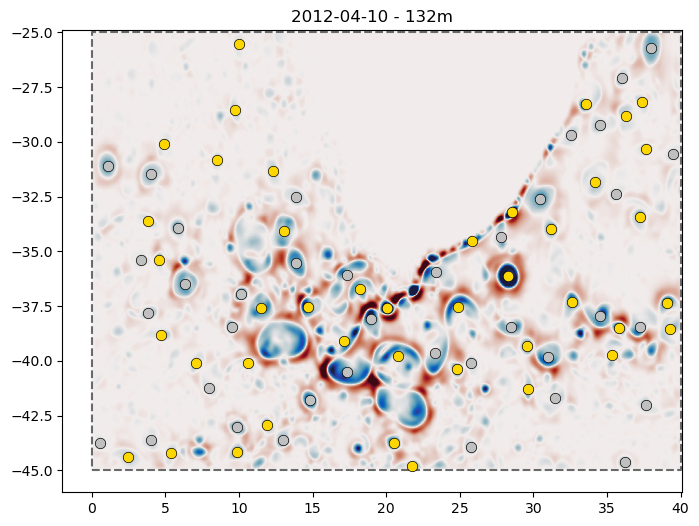

 10%|█         | 5/48 [06:22<54:38, 76.23s/it]

> Starting: 20120410, 173m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


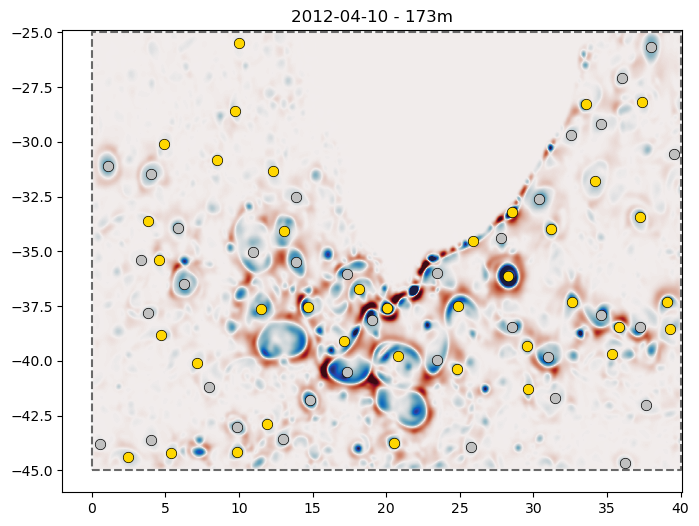

 12%|█▎        | 6/48 [07:37<53:08, 75.93s/it]

> Starting: 20120410, 210m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


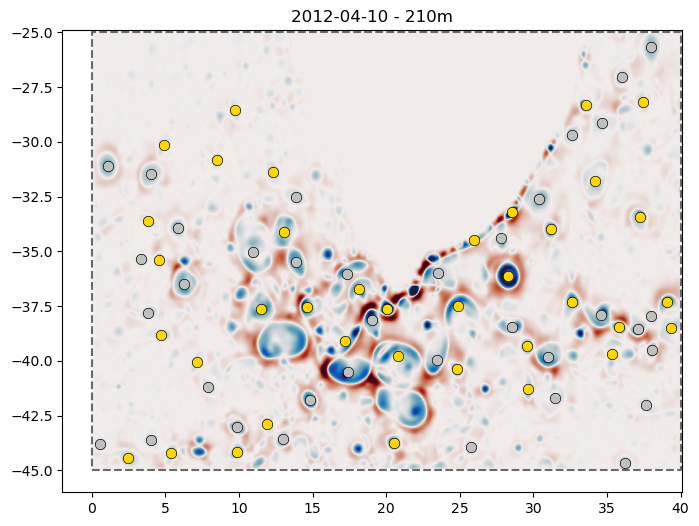

 15%|█▍        | 7/48 [08:52<51:31, 75.41s/it]

> Starting: 20120410, 253m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


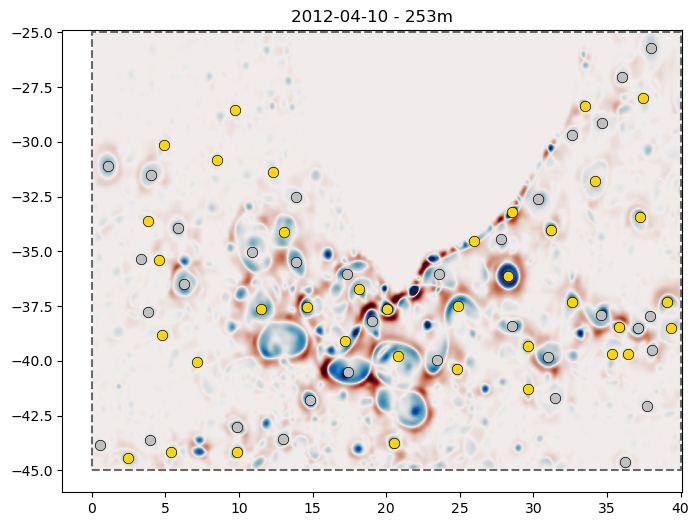

 17%|█▋        | 8/48 [10:06<50:09, 75.23s/it]

> Starting: 20120410, 286m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


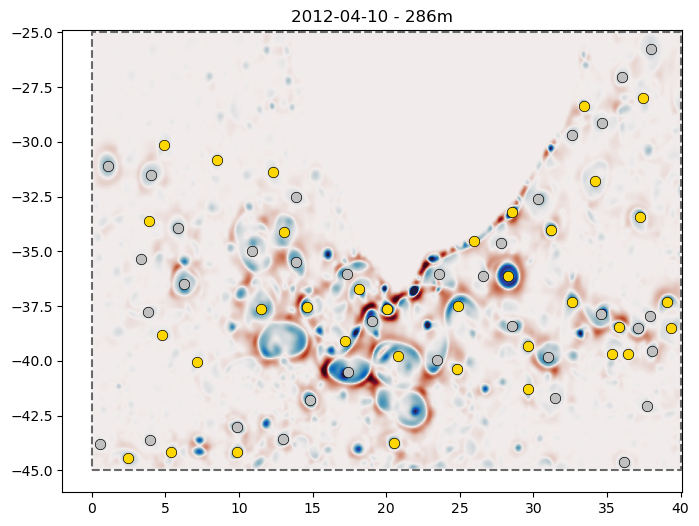

 19%|█▉        | 9/48 [11:21<48:42, 74.95s/it]

> Starting: 20120410, 323m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


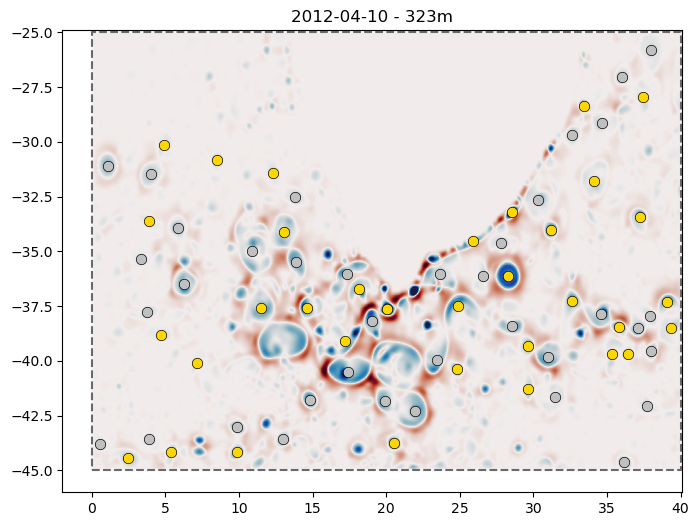

 21%|██        | 10/48 [12:34<47:11, 74.52s/it]

> Starting: 20120410, 365m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


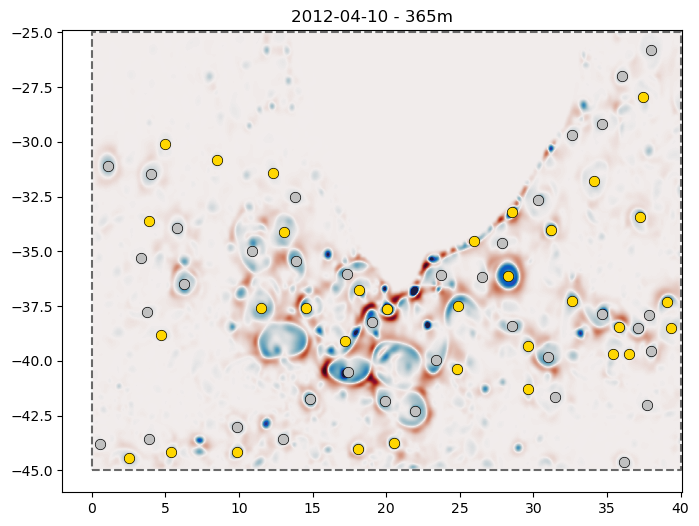

 23%|██▎       | 11/48 [13:46<45:22, 73.58s/it]

> Starting: 20120410, 412m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


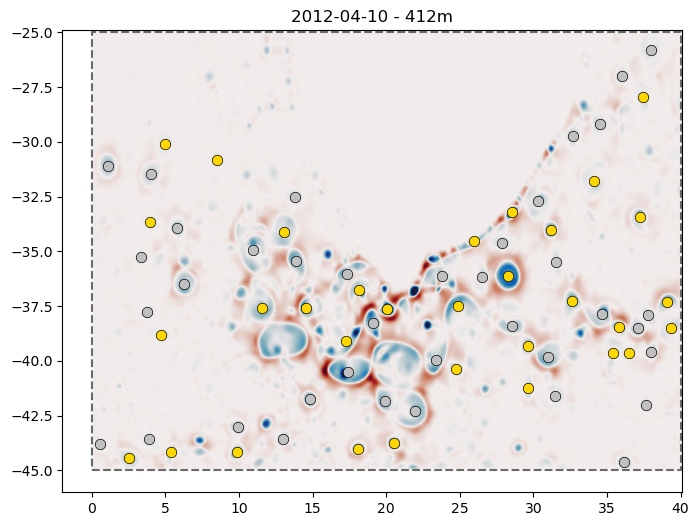

 25%|██▌       | 12/48 [14:59<44:08, 73.58s/it]

> Starting: 20120410, 465m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


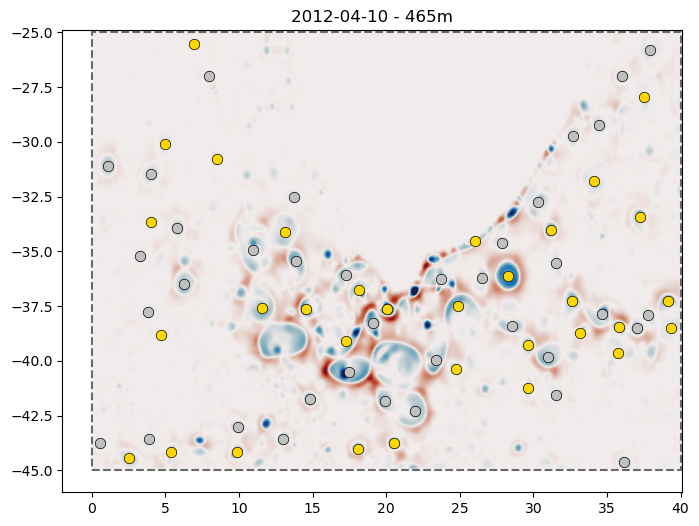

 27%|██▋       | 13/48 [16:11<42:34, 72.99s/it]

> Starting: 20120410, 525m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


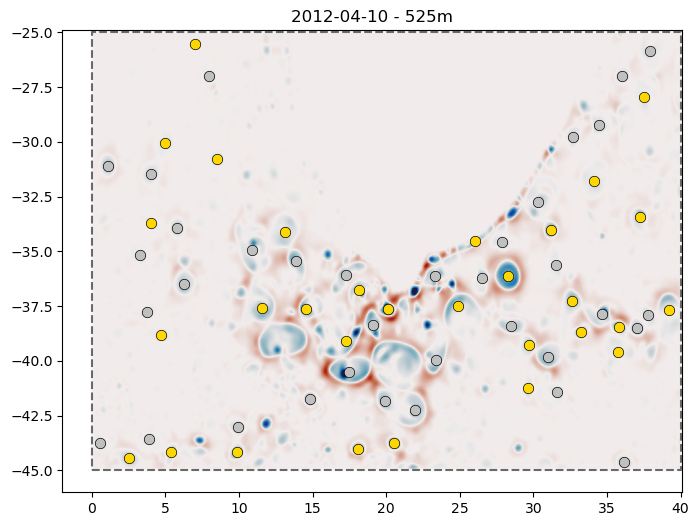

 29%|██▉       | 14/48 [17:25<41:28, 73.20s/it]

> Starting: 20120410, 592m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


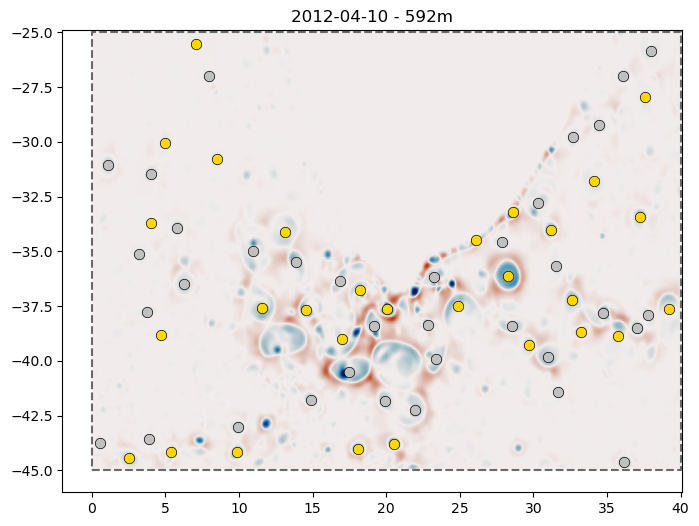

 31%|███▏      | 15/48 [18:37<40:03, 72.82s/it]

> Starting: 20120410, 668m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


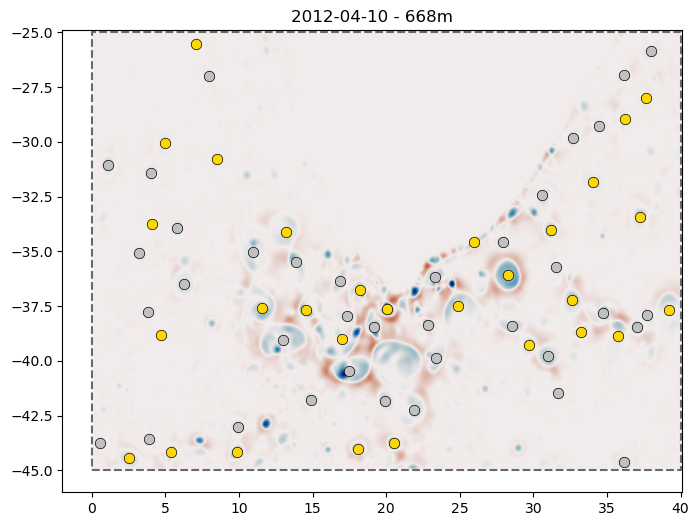

 33%|███▎      | 16/48 [19:49<38:49, 72.78s/it]

> Starting: 20120410, 753m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


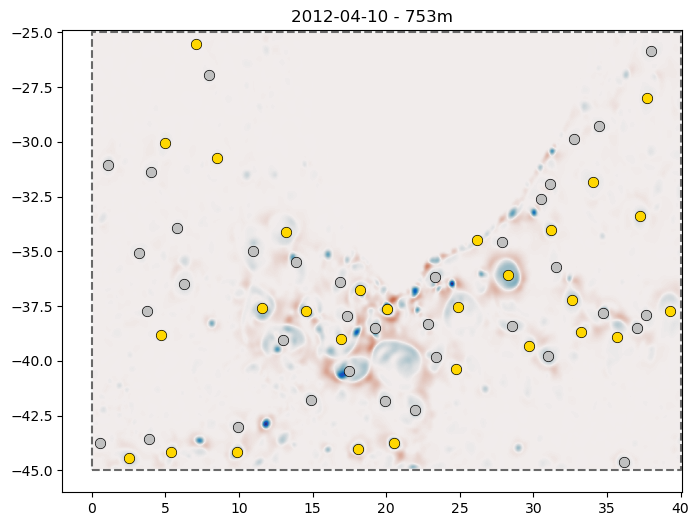

 35%|███▌      | 17/48 [21:02<37:39, 72.88s/it]

> Starting: 20120410, 848m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


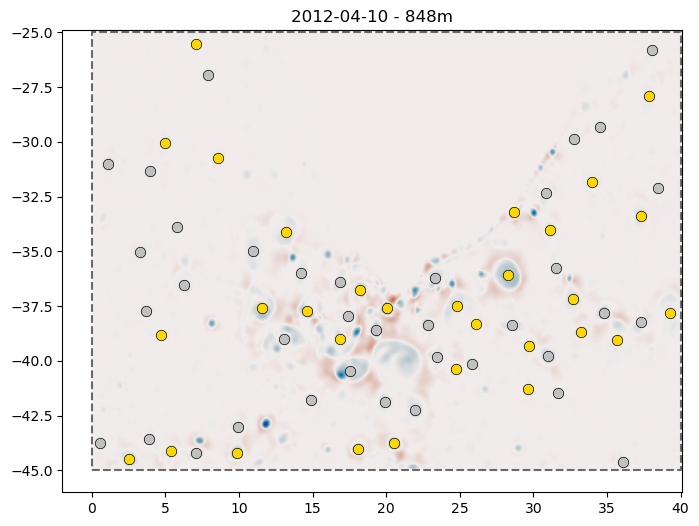

 38%|███▊      | 18/48 [22:14<36:18, 72.62s/it]

> Starting: 20120410, 952m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


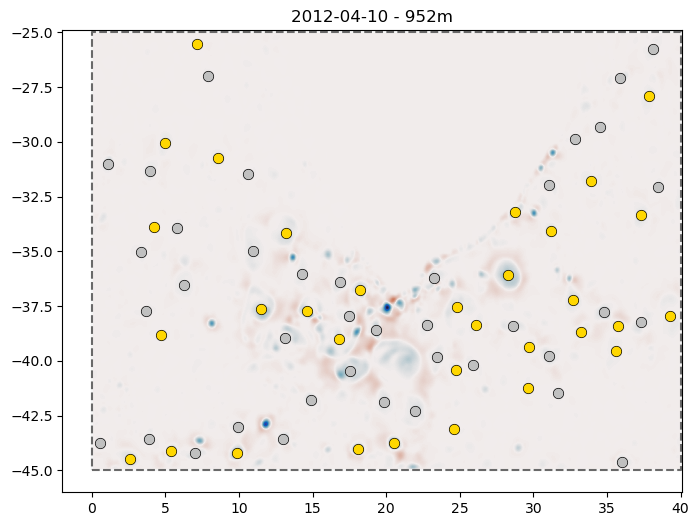

 40%|███▉      | 19/48 [23:29<35:22, 73.19s/it]

> Starting: 20120410, 1066m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


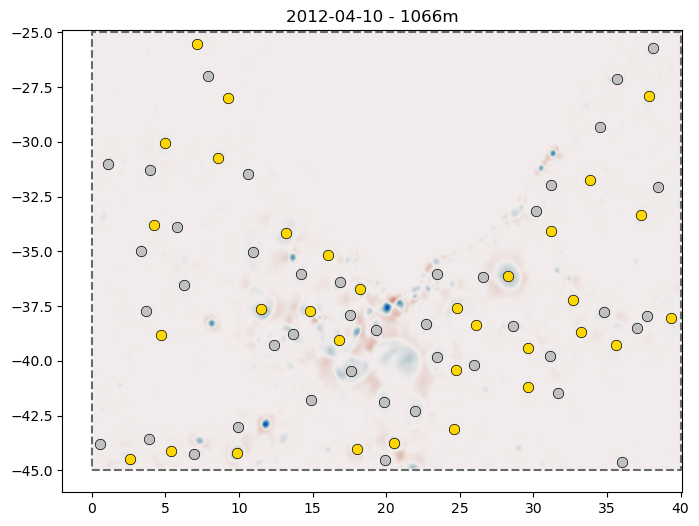

 42%|████▏     | 20/48 [24:45<34:35, 74.11s/it]

> Starting: 20120410, 1189m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


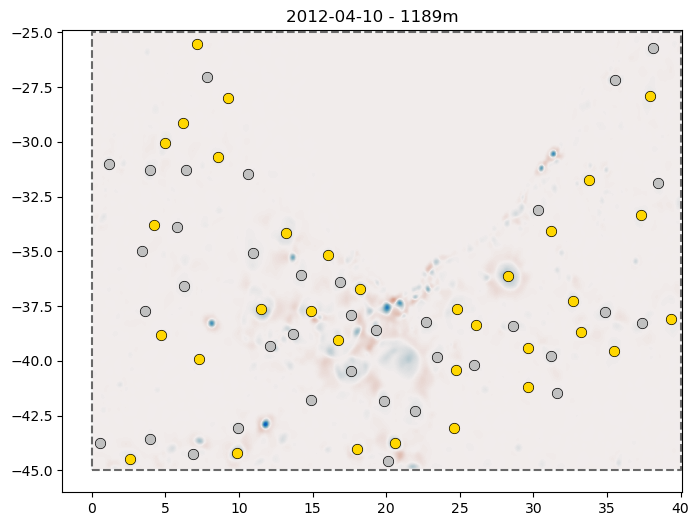

 44%|████▍     | 21/48 [26:00<33:30, 74.48s/it]

> Starting: 20120410, 1321m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


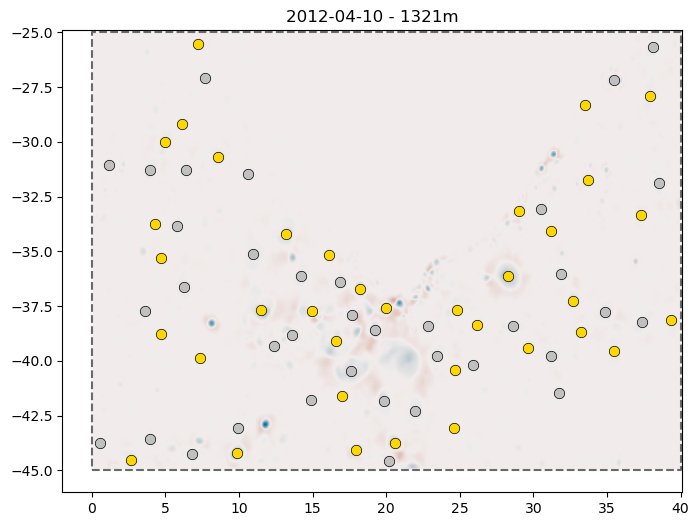

 46%|████▌     | 22/48 [27:18<32:36, 75.25s/it]

> Starting: 20120410, 1461m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


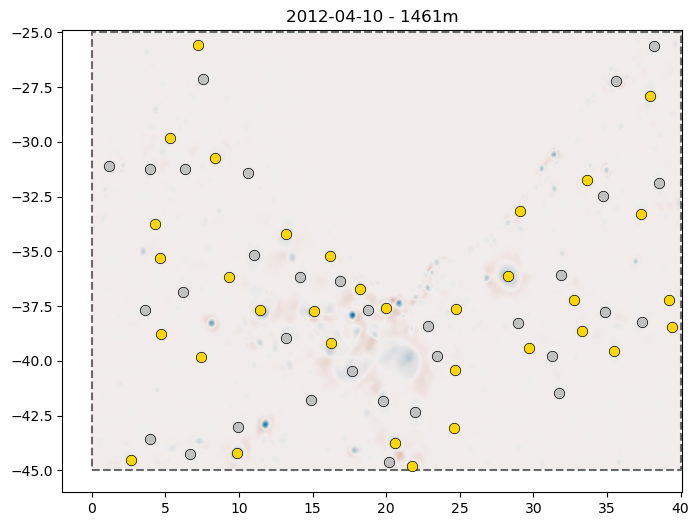

 48%|████▊     | 23/48 [28:34<31:32, 75.70s/it]

> Starting: 20120410, 1608m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


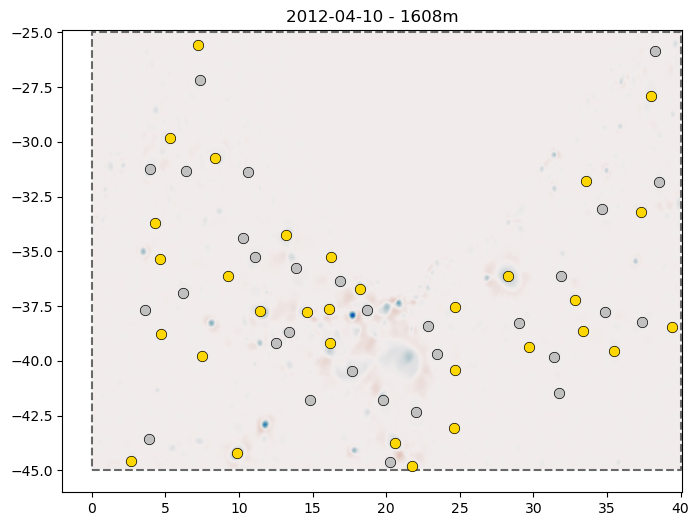

 50%|█████     | 24/48 [29:54<30:44, 76.84s/it]

> Starting: 20120410, 1762m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


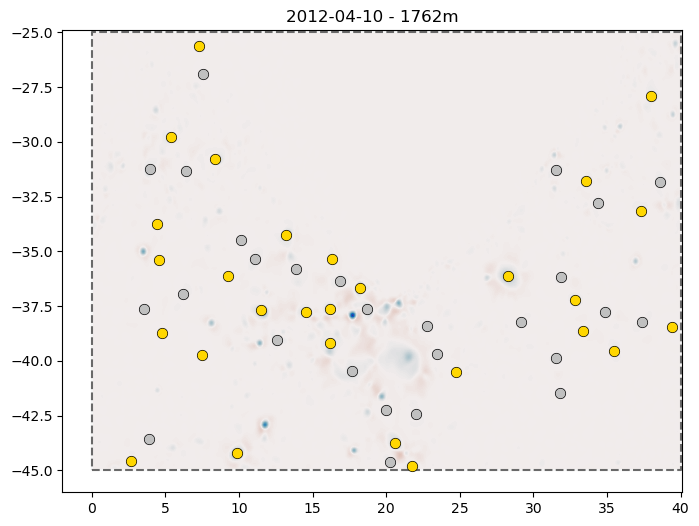

 52%|█████▏    | 25/48 [31:13<29:45, 77.63s/it]

> Starting: 20120410, 1922m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


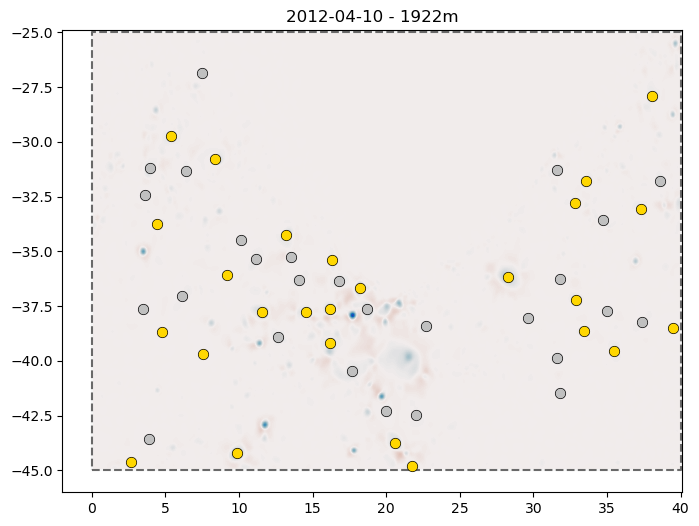

 54%|█████▍    | 26/48 [32:32<28:38, 78.11s/it]

> Starting: 20120410, 2086m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


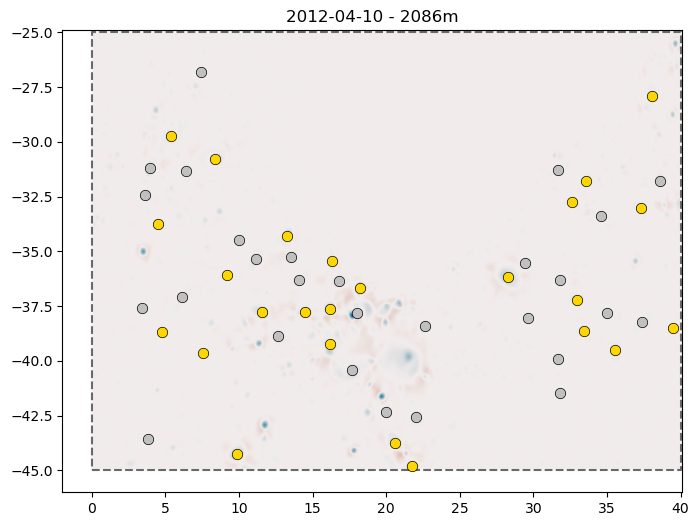

 56%|█████▋    | 27/48 [33:54<27:42, 79.15s/it]

> Starting: 20120410, 2255m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


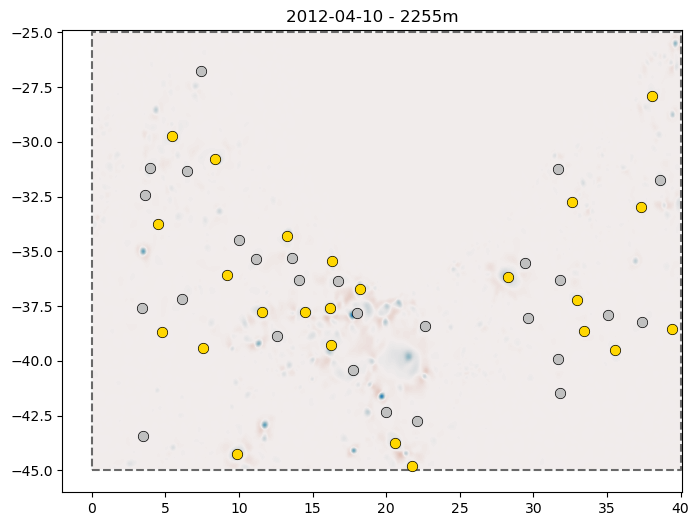

 58%|█████▊    | 28/48 [35:15<26:33, 79.67s/it]

> Starting: 20120410, 2428m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


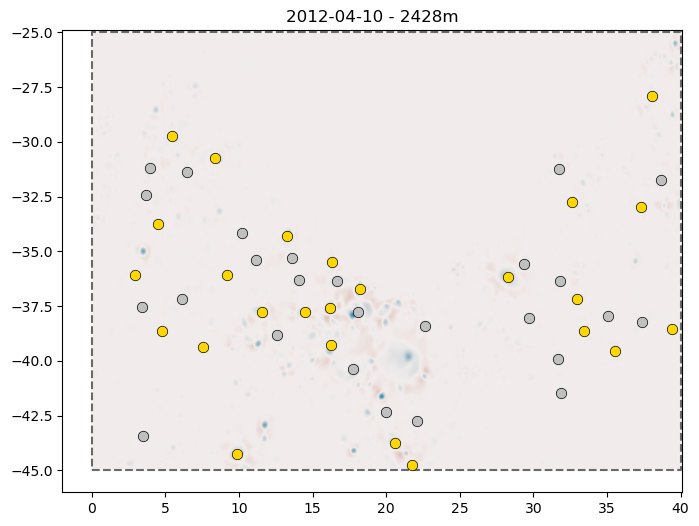

 60%|██████    | 29/48 [36:37<25:27, 80.41s/it]

> Starting: 20120410, 2603m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


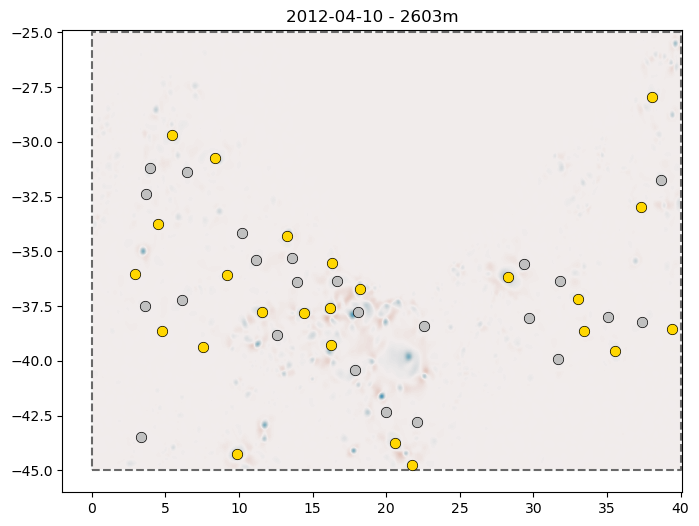

 62%|██████▎   | 30/48 [38:01<24:26, 81.47s/it]

> Starting: 20120410, 2782m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


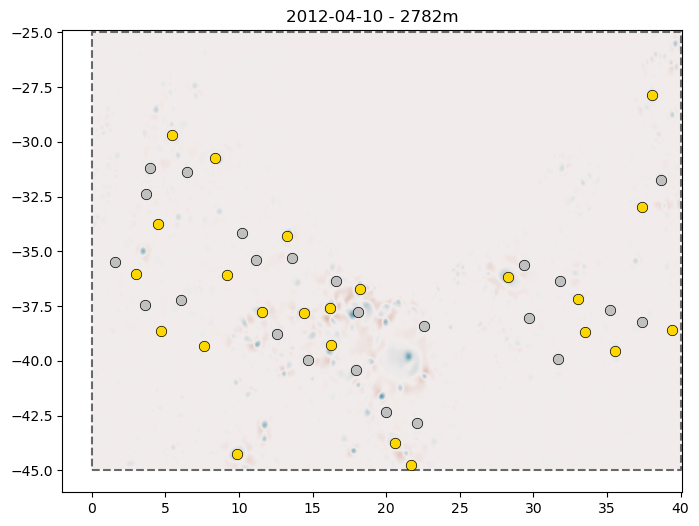

 65%|██████▍   | 31/48 [39:25<23:15, 82.12s/it]

> Starting: 20120410, 2963m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


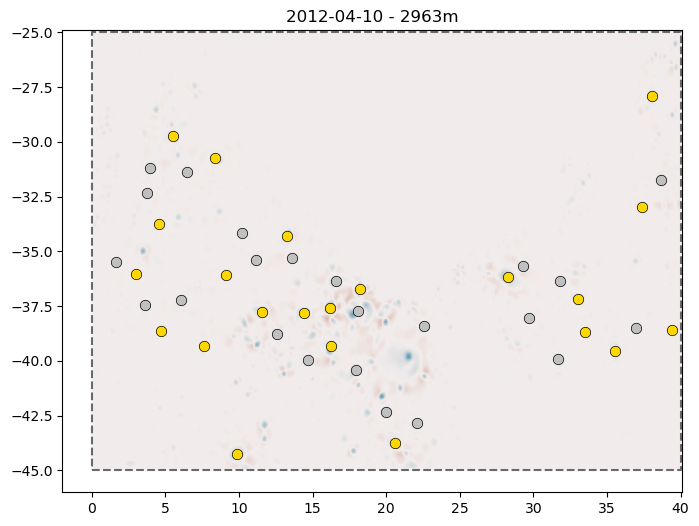

 67%|██████▋   | 32/48 [40:50<22:09, 83.08s/it]

> Starting: 20120410, 3146m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


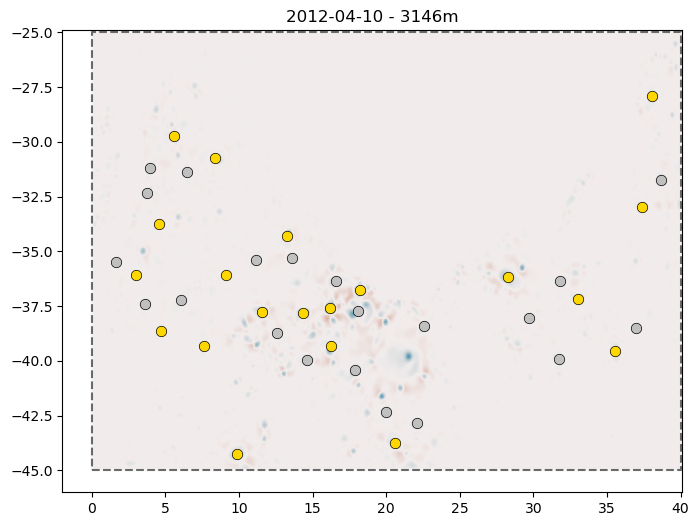

 69%|██████▉   | 33/48 [42:15<20:54, 83.64s/it]

> Starting: 20120410, 3331m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


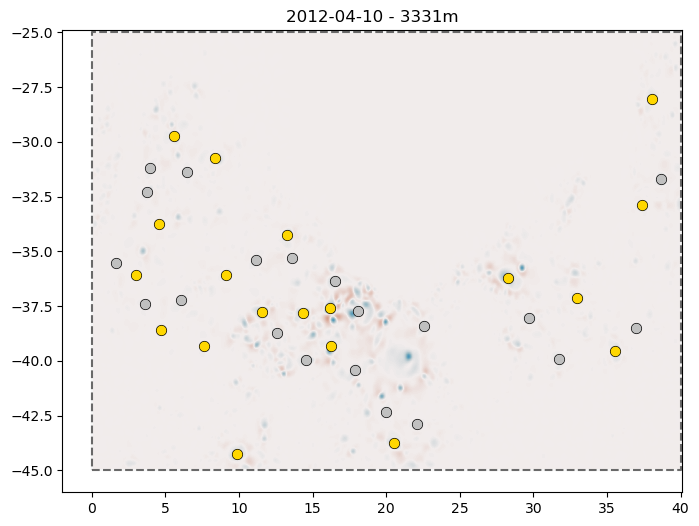

 71%|███████   | 34/48 [43:39<19:34, 83.88s/it]

> Starting: 20120410, 3518m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


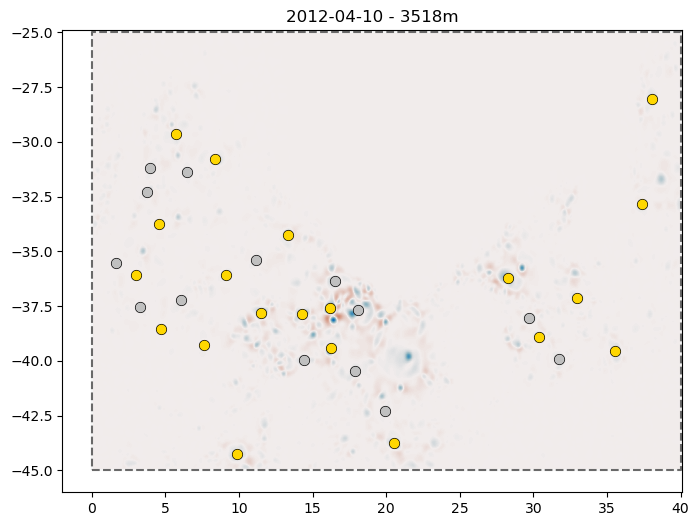

 73%|███████▎  | 35/48 [45:05<18:18, 84.49s/it]

> Starting: 20120410, 3706m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


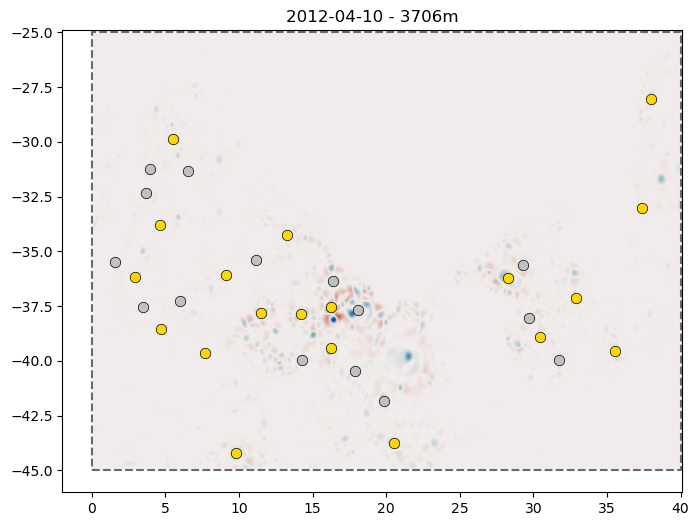

 75%|███████▌  | 36/48 [46:32<17:03, 85.30s/it]

> Starting: 20120410, 3896m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


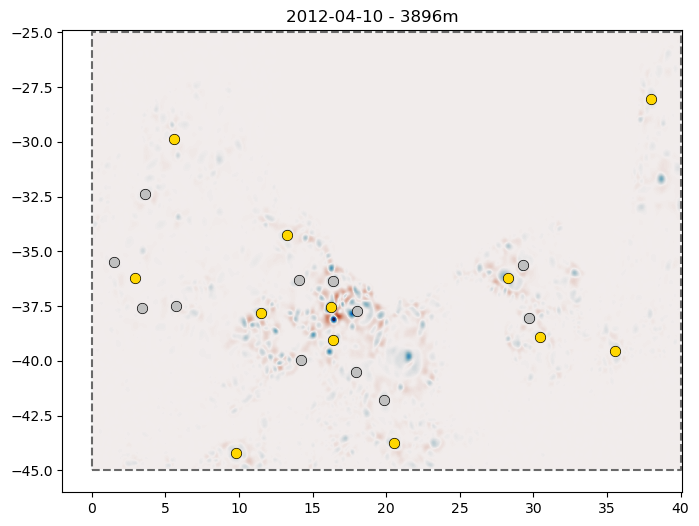

 77%|███████▋  | 37/48 [48:00<15:45, 86.00s/it]

> Starting: 20120410, 4086m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


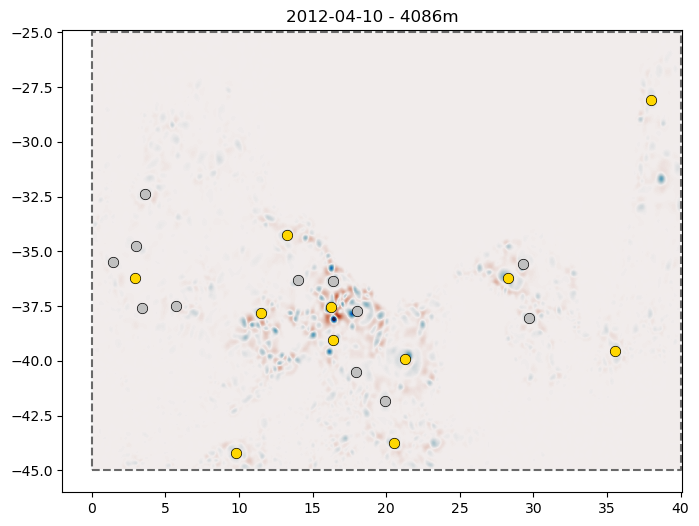

 79%|███████▉  | 38/48 [49:26<14:20, 86.08s/it]

> Starting: 20120410, 4279m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


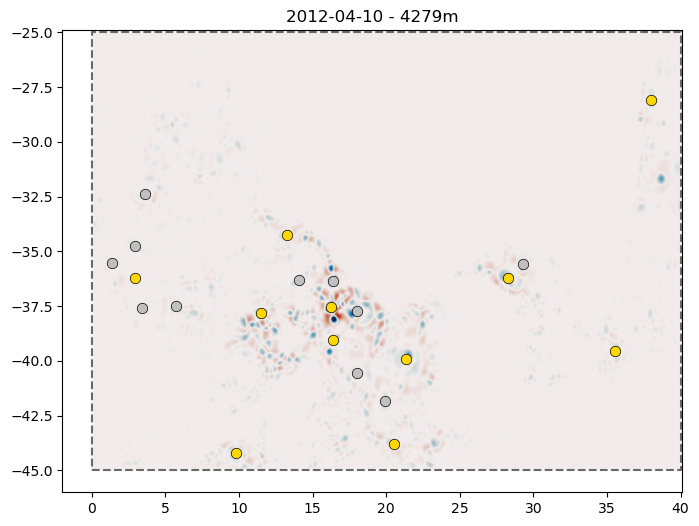

 81%|████████▏ | 39/48 [50:56<13:04, 87.20s/it]

> Starting: 20120410, 4472m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


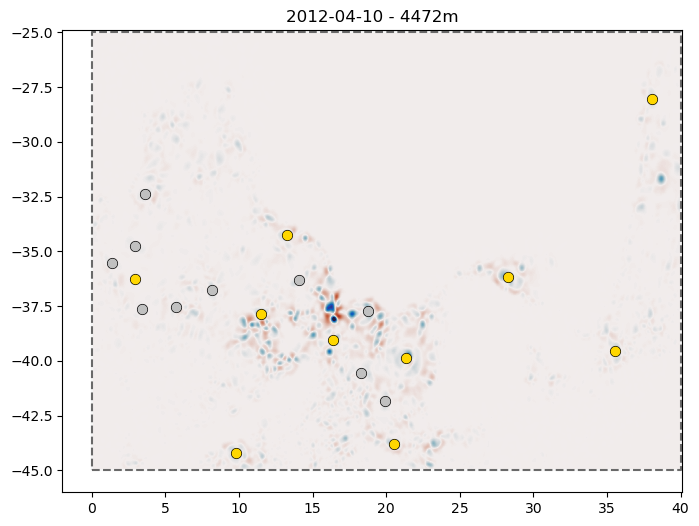

 83%|████████▎ | 40/48 [52:22<11:35, 86.93s/it]

> Starting: 20120410, 4666m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


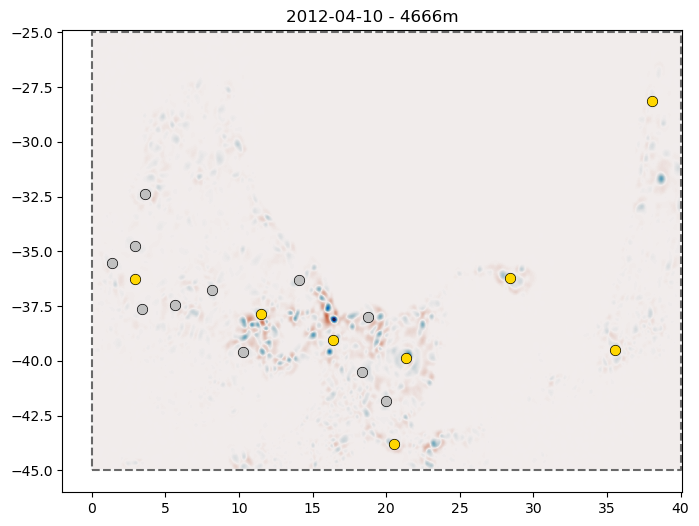

 85%|████████▌ | 41/48 [53:46<10:01, 85.97s/it]

> Starting: 20120410, 4861m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


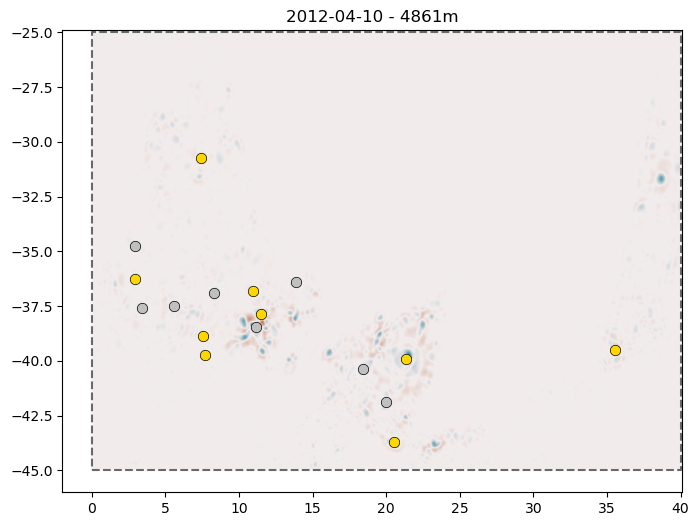

 88%|████████▊ | 42/48 [55:07<08:26, 84.37s/it]

> Starting: 20120410, 5057m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


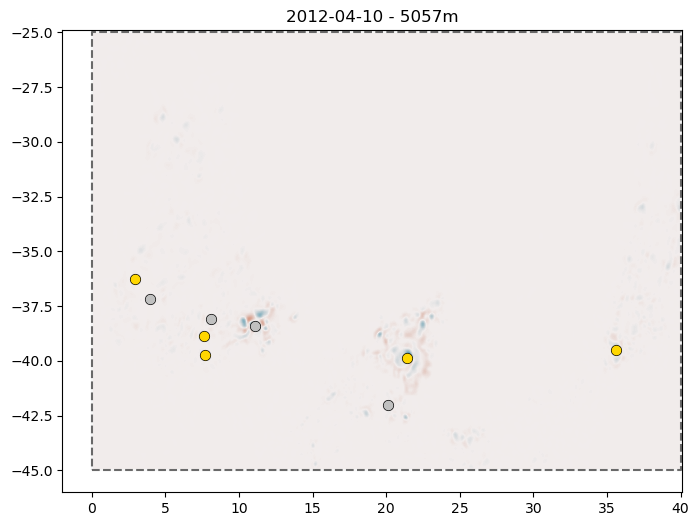

 90%|████████▉ | 43/48 [56:23<06:49, 81.86s/it]

> Starting: 20120410, 5254m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


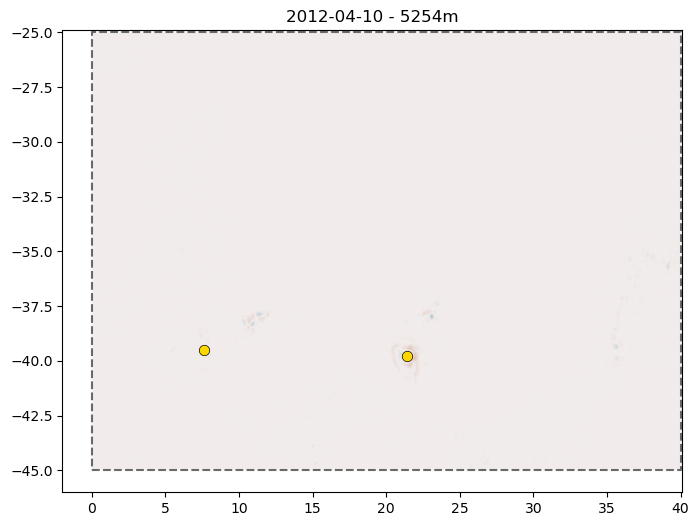

 92%|█████████▏| 44/48 [57:32<05:12, 78.04s/it]

> Starting: 20120410, 5452m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


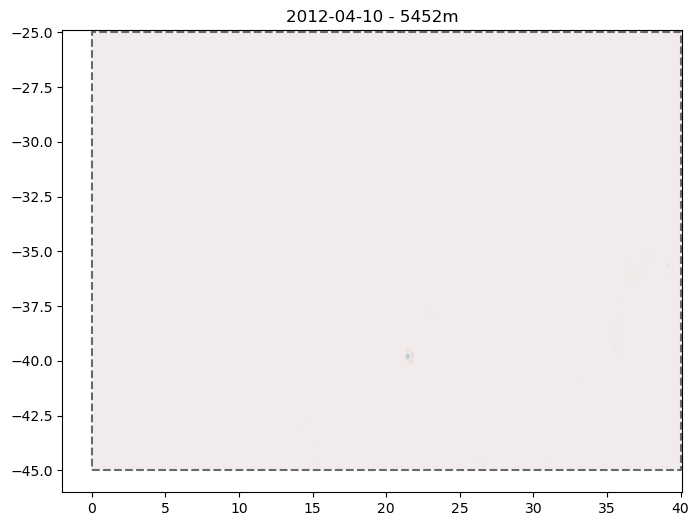

 94%|█████████▍| 45/48 [58:40<03:45, 75.19s/it]

No eddies detected for 2012-04-10. Skip ...
No eddies detected for 2012-04-11. Skip ...
No eddies detected for 2012-04-12. Skip ...
No eddies detected for 2012-04-13. Skip ...
No eddies detected for 2012-04-14. Skip ...
No eddies detected for 2012-04-15. Skip ...
No eddies detected for 2012-04-16. Skip ...
No eddies detected for 2012-04-17. Skip ...
No eddies detected for 2012-04-18. Skip ...
No eddies detected for 2012-04-19. Skip ...
No eddies detected for 2012-04-20. Skip ...
No eddies detected for 2012-04-21. Skip ...
No eddies detected for 2012-04-22. Skip ...
No eddies detected for 2012-04-23. Skip ...
No eddies detected for 2012-04-24. Skip ...
No eddies detected for 2012-04-25. Skip ...
No eddies detected for 2012-04-26. Skip ...
No eddies detected for 2012-04-27. Skip ...
No eddies detected for 2012-04-28. Skip ...
No eddies detected for 2012-04-29. Skip ...
No eddies detected for 2012-04-30. Skip ...
No eddies detected for 2012-05-02. Skip ...
No eddies detected for 2012-05-0

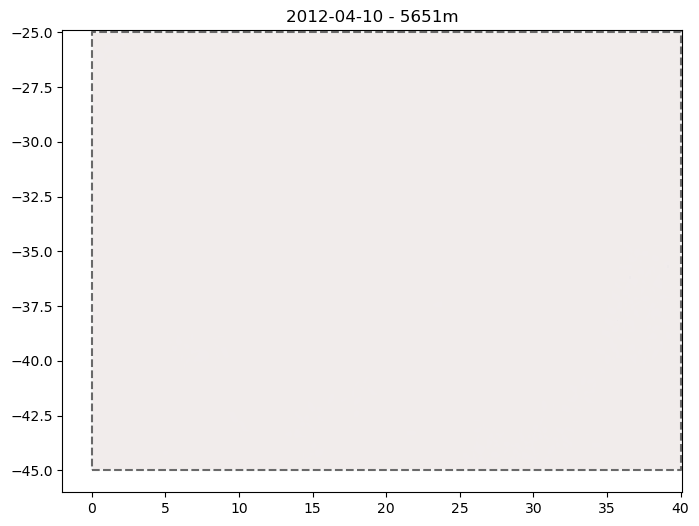

 96%|█████████▌| 46/48 [59:46<02:24, 72.26s/it]

No eddies detected for 2012-04-10. Skip ...
No eddies detected for 2012-04-11. Skip ...
No eddies detected for 2012-04-12. Skip ...
No eddies detected for 2012-04-13. Skip ...
No eddies detected for 2012-04-14. Skip ...
No eddies detected for 2012-04-15. Skip ...
No eddies detected for 2012-04-16. Skip ...
No eddies detected for 2012-04-17. Skip ...
No eddies detected for 2012-04-18. Skip ...
No eddies detected for 2012-04-19. Skip ...
No eddies detected for 2012-04-20. Skip ...
No eddies detected for 2012-04-21. Skip ...
No eddies detected for 2012-04-22. Skip ...
No eddies detected for 2012-04-23. Skip ...
No eddies detected for 2012-04-24. Skip ...
No eddies detected for 2012-04-25. Skip ...
No eddies detected for 2012-04-26. Skip ...
No eddies detected for 2012-04-27. Skip ...
No eddies detected for 2012-04-28. Skip ...
No eddies detected for 2012-04-29. Skip ...
No eddies detected for 2012-04-30. Skip ...
No eddies detected for 2012-05-01. Skip ...
No eddies detected for 2012-05-0

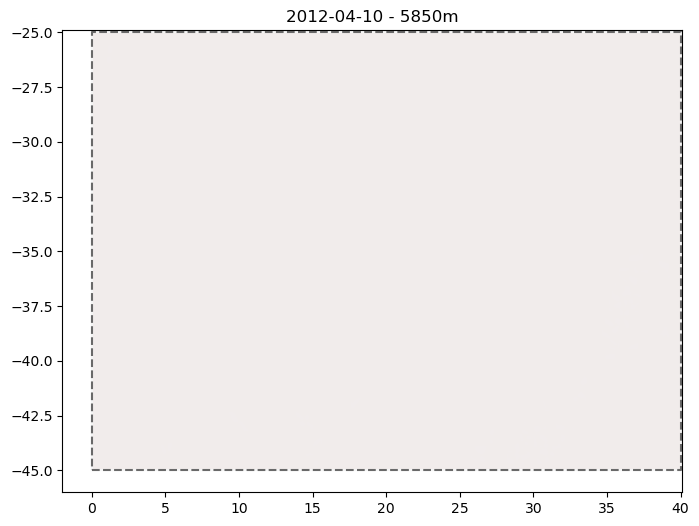

 98%|█████████▊| 47/48 [1:00:50<01:09, 69.77s/it]

No eddies detected for 2012-04-10. Skip ...
No eddies detected for 2012-04-11. Skip ...
No eddies detected for 2012-04-12. Skip ...
No eddies detected for 2012-04-13. Skip ...
No eddies detected for 2012-04-14. Skip ...
No eddies detected for 2012-04-15. Skip ...
No eddies detected for 2012-04-16. Skip ...
No eddies detected for 2012-04-17. Skip ...
No eddies detected for 2012-04-18. Skip ...
No eddies detected for 2012-04-19. Skip ...
No eddies detected for 2012-04-20. Skip ...
No eddies detected for 2012-04-21. Skip ...
No eddies detected for 2012-04-22. Skip ...
No eddies detected for 2012-04-23. Skip ...
No eddies detected for 2012-04-24. Skip ...
No eddies detected for 2012-04-25. Skip ...
No eddies detected for 2012-04-26. Skip ...
No eddies detected for 2012-04-27. Skip ...
No eddies detected for 2012-04-28. Skip ...
No eddies detected for 2012-04-29. Skip ...
No eddies detected for 2012-04-30. Skip ...
No eddies detected for 2012-05-01. Skip ...
No eddies detected for 2012-05-0

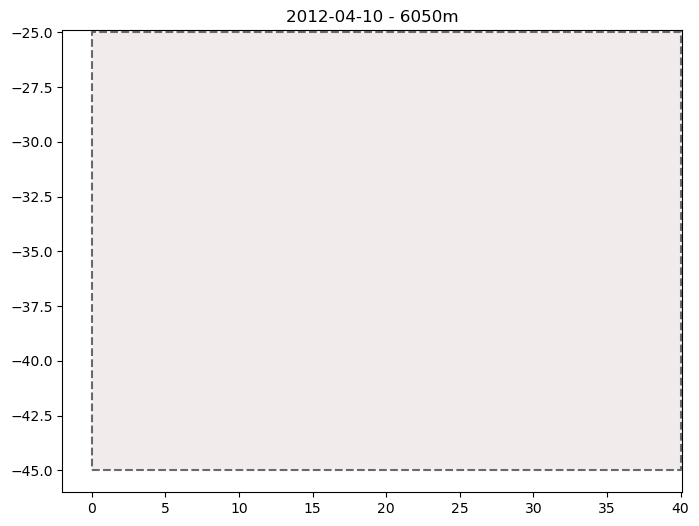

100%|██████████| 48/48 [1:01:52<00:00, 77.34s/it]

No eddies detected for 2012-04-10. Skip ...
No eddies detected for 2012-04-11. Skip ...
No eddies detected for 2012-04-12. Skip ...
No eddies detected for 2012-04-13. Skip ...
No eddies detected for 2012-04-14. Skip ...
No eddies detected for 2012-04-15. Skip ...
No eddies detected for 2012-04-16. Skip ...
No eddies detected for 2012-04-17. Skip ...
No eddies detected for 2012-04-18. Skip ...
No eddies detected for 2012-04-19. Skip ...
No eddies detected for 2012-04-20. Skip ...
No eddies detected for 2012-04-21. Skip ...
No eddies detected for 2012-04-22. Skip ...
No eddies detected for 2012-04-23. Skip ...
No eddies detected for 2012-04-24. Skip ...
No eddies detected for 2012-04-25. Skip ...
No eddies detected for 2012-04-26. Skip ...
No eddies detected for 2012-04-27. Skip ...
No eddies detected for 2012-04-28. Skip ...
No eddies detected for 2012-04-29. Skip ...
No eddies detected for 2012-04-30. Skip ...
No eddies detected for 2012-05-01. Skip ...
No eddies detected for 2012-05-0

In [9]:
#for (datestart, dateend) in tqdm(periods):
#    print(f"> Starting: {datestart.replace("-", "")}-{dateend.replace("-", "")} ...")
dates = pd.date_range(start=datestart, end=dateend)
dates_array = dates.to_numpy()
for (depth, depth_index) in tqdm(depth_information):
    print(f"> Starting: {datestart.replace('-', '')}, {depth}m ...")
    outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!
    if os.path.exists(outpath + f'Eddies_{dateend}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle'):
        print(f'Last file ({dateend}) already exists, skipping...')
        continue
    data_int = xr.open_dataset(outpath + f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}_rolling-{wx}.nc')
    detection_parameters['OW_thr'] = data_int

    # We detect eddies at level XX (as we only calculated the Okubo-Weiss parameter at this level)
    eddies = et.detection.detect_OW(data_int.isel(z=depth_index), detection_parameters, 'OW', 'vort', regrid_avoided=False,     
                                    use_bags=False, use_mp=True,mp_cpu=12)
    
    # Plot
    plot_eddies(data_int, eddies, detection_parameters, datestart,depth)

    # Save
    for i in np.arange(0, len(eddies)):
        if not eddies[i]:
            print(f"No eddies detected for {str(dates_array[i])[0:10]}. Skip ...")
            continue 
        datestring = str(eddies[i][0]['time'])[0:10] #[0:13] YYYY-MM-DDTHH, e.g. 2012-06-30T02 for 2am at 30 June 2012
        with open(outpath + 'Eddies_' + str(datestring) + f'_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()


In [10]:
end_time = time.time()

execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {hours:02}:{minutes:02}:{seconds:02}")

Execution time: 01:01:52
